# News Recommendation System

by 
<b>Abhishek Singh (aulakh.abhishek@gmail.com)</b> 


Objective
---

In the below code we will be trying to solve the issue of revenue leakage and user drop for online news platforms by personalising user tastes and introducing new content to its users at the start of the day on the home page of the application. 

The plan will be to assess these recommendations by tracking whether the user clicks on those items or not. Moreover, once the user clicks on any news item A, it wants to recommend news similar to the news A, at the bottom of the page of the news item A.

---

The recommender systems are built using CI&T dataset with news articles from number of websites with topics around sports, politics, technology and many others. 

Our code will build an appropriate recommendation system that would:

Recommend new top 10 relevant articles to a user when he visits the app at the start of the day
Recommend top 10 similar news articles that match the ones clicked by the user. 


The code project will try out


1. Popularity method 
2. Collobartive Filtering
3. Content Based Filtering
4. ALS 
5. Hybrid systems 


for feeding personalised news recommendation to users on the online news platform 

## 1. Library Imports

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import scipy
import sklearn
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')



warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid", palette="pastel")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. User interaction & platform content dataset 

In [2]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/<path_to_data>/'
print(root_path)

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Capstone-NRS/Capstone/data/


In [3]:
consumer = pd.read_csv(root_path + 'consumer_transanctions.csv',encoding='ISO-8859-1',low_memory=False)
platform = pd.read_csv(root_path + 'platform_content.csv',encoding='ISO-8859-1')

## 3. EDA

<b>Consumer Interactions Dataset</b>

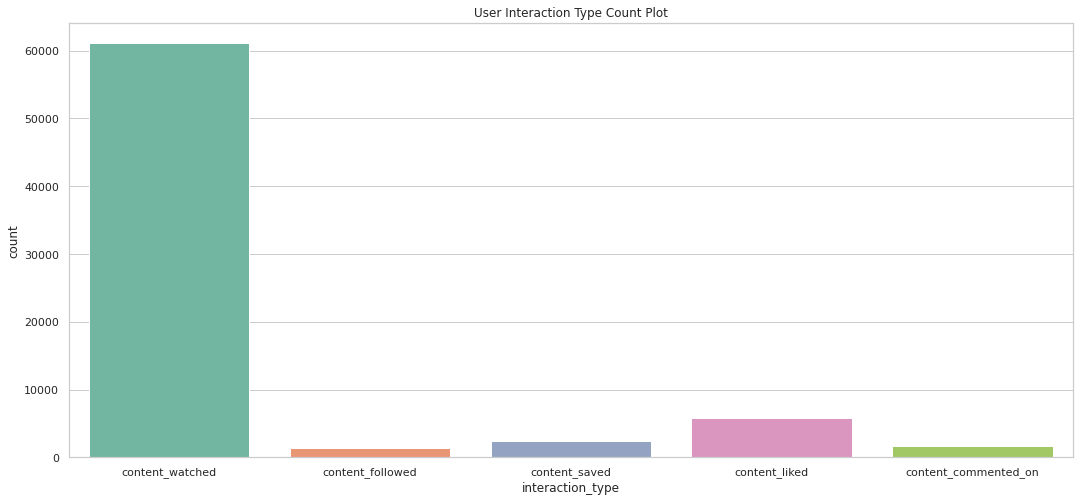

In [4]:
plt.figure(figsize = (18,8))
ax = sns.countplot(x="interaction_type", data=consumer,palette="Set2")
plt.title('User Interaction Type Count Plot')
plt.show()

As expected most of the users tend to only watch and read the content i.e. news article and very less follow, like and comment on them

---

Let's explore the country in which the user interaction took place 

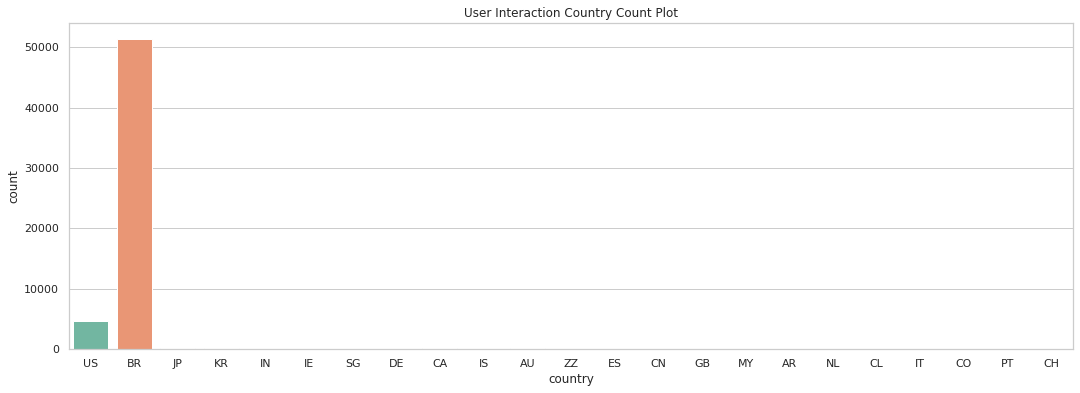

In [5]:
plt.figure(figsize = (18,6))
ax = sns.countplot(x="country", data=consumer,palette="Set2")
plt.title('User Interaction Country Count Plot')
plt.show()

This shows that most of the articles are interacted by users in Brazil & US. 

---

Distirbution of User interaction on the platform 

In [6]:
consumer_interactions_count_df = consumer.groupby(['consumer_id', 'item_id']).size().groupby('consumer_id').size().reset_index()
consumer_interactions_count_df.columns = ['consumer_id','count']
consumer_interactions_count_df.tail(2)

,consumer_id,count
1893,9199170757466086545,14
1894,9210530975708218054,63


<Figure size 1296x432 with 0 Axes>

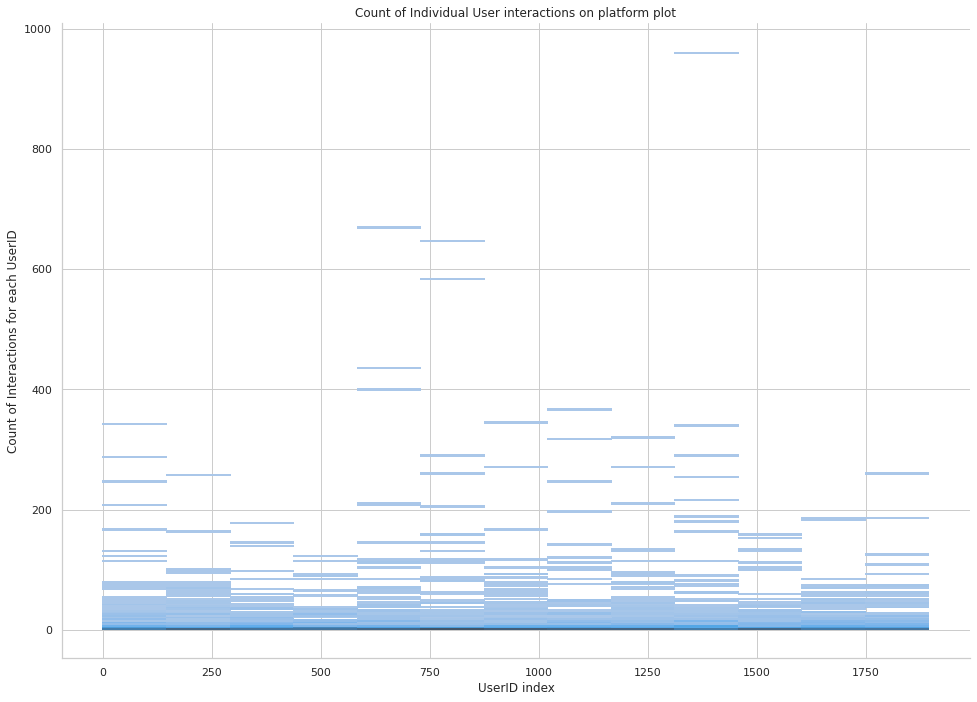

In [7]:
plt.figure(figsize = (18,6))
ax = sns.displot(y="count",x=consumer_interactions_count_df.index, data=consumer_interactions_count_df, palette="Set2")
ax.fig.set_figwidth(16)
ax.fig.set_figheight(10)
ax.set(xlabel='UserID index', ylabel='Count of Interactions for each UserID')
plt.title('Count of Individual User interactions on platform plot')
plt.show()

Clearly there are few users with very high interaction on the platform while generally the interaction count is less than 200 on average

---

<b>Platform Content Dataset</b>

Next. we can check the plot for the content pulled out vs content present on the platform

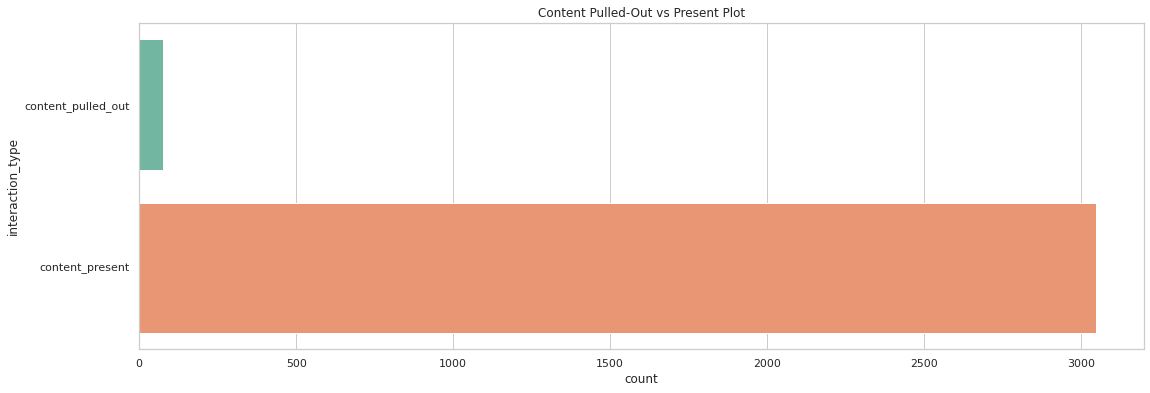

In [8]:
plt.figure(figsize = (18,6))
ax = sns.countplot(y="interaction_type", data=platform, palette="Set2")
plt.title('Content Pulled-Out vs Present Plot')
plt.show()

Let's find out the distribution of the text words inside each of the article on platform

In [9]:
number_of_keywords = []  
for keywords in platform['text_description']:
    n_keywords = len(keywords.split(','))
    number_of_keywords.append(n_keywords)

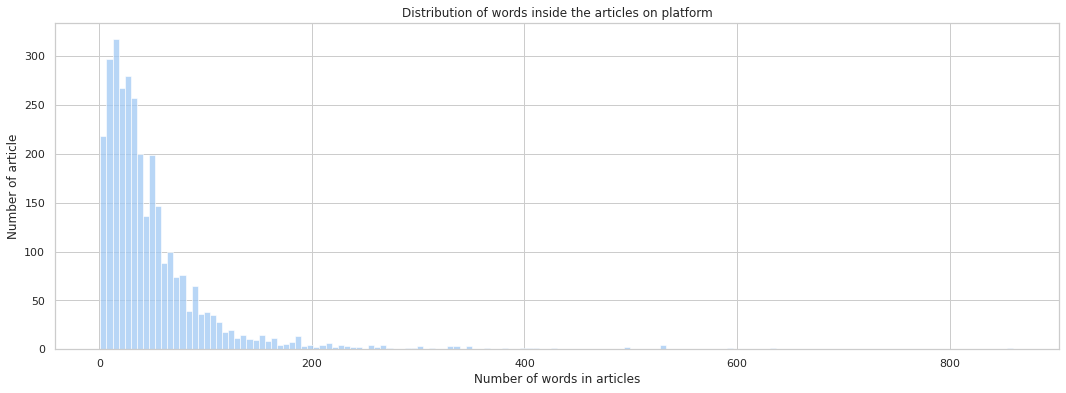

In [10]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.histplot(number_of_keywords, ax=ax)
plt.xlabel('Number of words in articles')
plt.ylabel('Number of article')
plt.title('Distribution of words inside the articles on platform')
plt.show()

We can observe that number of articles have less than 200 words inside them while there are very few which have more than than

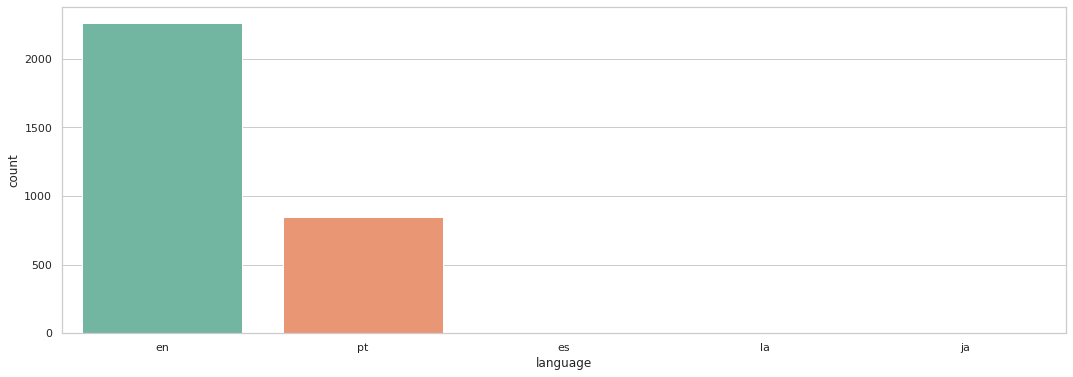

In [11]:
plt.figure(figsize = (18,6))
ax = sns.countplot(x="language", data=platform, palette="Set2")

Clearly, most of the articles are in english and portugese language

## 4. Feature Extraction & Reengineering

### Consumer interactions dataset

Let's explore the consumer dataset which contains the user interactions with the platform and apply feature re-engineering 

In [12]:
consumer

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
72307,1485190425,content_liked,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR
72308,1485190425,content_watched,-5813211845057621660,102305705598210278,5527770709392883642,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
72309,1485190072,content_watched,-1999468346928419252,-9196668942822132778,-8300596454915870873,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,SP,BR
72310,1485190434,content_watched,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR


The consumer dataset contains 72,312 rows and 8 columns. As described in the problem 

The consumer dataset contains field 'interaction_type' which shows the type of interaction user had with the news article on the iPrint platform. We will impute the rating values based on this feature ‘interaction type’ with the highest weightage to content_followed, followed by content_commented_on, content saved, content liked and content_watched. 

In [13]:
consumer['ratings'] = consumer['interaction_type'].map({
    'content_followed':5,
    'content_commented_on':4,
    'content_saved':3,
    'content_liked':2,
    'content_watched':1
})
consumer

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,ratings
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,5
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...
72307,1485190425,content_liked,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR,2
72308,1485190425,content_watched,-5813211845057621660,102305705598210278,5527770709392883642,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1
72309,1485190072,content_watched,-1999468346928419252,-9196668942822132778,-8300596454915870873,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,SP,BR,1
72310,1485190434,content_watched,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR,1


In order to handle Cold-Start problem, We will be taking only users which had at least 3 transactions on the platform

In [14]:
users_interactions_count_df = consumer.groupby(['consumer_id', 'item_id']).size().groupby('consumer_id').size()
print('# users: %d' % len(users_interactions_count_df))

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 3].reset_index()[['consumer_id']]
print('# users with at least 3 interactions: %d' % len(users_with_enough_interactions_df))


# users: 1895
# users with at least 3 interactions: 1400


Filter the main user interaction dataset with only the users with enough interactions

In [15]:
print('# of interactions: %d' % len(consumer))
interactions_from_selected_users_df = consumer.merge(users_with_enough_interactions_df, how = 'right',left_on = 'consumer_id', right_on = 'consumer_id')

print('# of interactions from users with at least 3 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 72312
# of interactions from users with at least 3 interactions: 71244


Smoothening of the ratings columns 

In [16]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

In [17]:
interactions_full_df = interactions_from_selected_users_df.groupby(['consumer_id', 'item_id'])['ratings'].sum().apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))

# of unique user/item interactions: 39995


Final user interactions dataset with only consumer_id, item_id and smoothened ratings features 

In [18]:
interactions_full_df

,consumer_id,item_id,ratings
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
...,...,...,...
39990,9210530975708218054,8477804012624580461,3.584963
39991,9210530975708218054,8526042588044002101,1.000000
39992,9210530975708218054,8856169137131817223,1.000000
39993,9210530975708218054,8869347744613364434,1.000000


### Platform Content Dataset 

In [19]:
print(platform.shape)
platform.head(3)

(3122, 13)


,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


As per the requirement, users will only be recommended the article which are not pulled out from the platform and are in english language, thus we will filter the platform dataset on 'interaction_type' to contain only the category of 'content_present' and select the language on 'en' (English)

In [20]:
platform = platform.loc[(platform['interaction_type'] == 'content_present') &  (platform['language'] == 'en')] 
platform.shape

(2211, 13)

Let's filter the item_id, title and item_url from platform in order to use in the recommendations later 

In [21]:
content = platform[['item_id','title','item_url',]]
content

,item_id,title,item_url
1,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact...",http://www.nytimes.com/2016/03/28/business/dea...
2,-7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins O...,http://cointelegraph.com/news/bitcoin-future-w...
3,-6151852268067518688,Google Data Center 360Â° Tour,https://cloudplatform.googleblog.com/2016/03/G...
4,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockc...",https://bitcoinmagazine.com/articles/ibm-wants...
5,-2826566343807132236,IEEE to Talk Blockchain at Cloud Computing Oxf...,http://www.coindesk.com/ieee-blockchain-oxford...
...,...,...,...
3116,4675505028897335428,Swift Top 10 Articles For The Past Year (v.2017),https://medium.mybridge.co/swift-top-10-articl...
3118,-3295913657316686039,Amazon takes on Skype and GoToMeeting with its...,https://thenextweb.com/apps/2017/02/14/amazon-...
3119,3618271604906293310,Code.org 2016 Annual Report,https://code.org/about/2016
3120,6607431762270322325,JPMorgan Software Does in Seconds What Took La...,https://www.bloomberg.com/news/articles/2017-0...


## 5. Splitting the User Interactions dataset into Train & Test set

In [22]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df, test_size=0.20,random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 31996
# interactions on Test set: 7999


We have around 32k records in training while 8k records in the test. 

Let's set indexing by consumer_id in the full, train and test set to speed up the searches during evaluation

In [23]:
interactions_full_indexed_df = interactions_full_df.set_index('consumer_id')
interactions_train_indexed_df = interactions_train_df.set_index('consumer_id')
interactions_test_indexed_df = interactions_test_df.set_index('consumer_id')

We will be performing evaluation using the test set which has 7999 rows 

In [24]:
interactions_test_indexed_df

,item_id,ratings
consumer_id,,
-5375964707198876331,-7722236679806608274,2.0
-2626634673110551643,8559816910657872807,1.0
8195788452563155020,-7217198366041991957,1.0
-3933783680725097100,-3071732669882279801,1.0
-534549863526737439,-348408475077850711,2.0
...,...,...
1116121227607581999,8786528563105605644,1.0
1960539917229374622,3825866166263569974,2.0
-3390049372067052505,-3363563881552061188,1.0


In [25]:
def get_items_interacted(consumer_id, interactions_df):
    # Get the consumer id interaction data from the passed dataframe
    try:
      x = interactions_df.loc[interactions_df.index == consumer_id]
      if not x.empty:
        interacted_items = interactions_df.loc[consumer_id]['item_id']
      else:
        interacted_items = interactions_df.loc[interactions_df.index == consumer_id]['item_id']
    except:
      print('Something wrong with finding the items interacted')
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [26]:
#consumer_id = 7786886764401143933
consumer_id = 8572969747961902966
interacted_items = interactions_train_indexed_df.loc[interactions_train_indexed_df.index == consumer_id]['item_id']
interacted_items

consumer_id
8572969747961902966   -5912792039759735631
8572969747961902966     374352050712569304
8572969747961902966   -1654063646246197191
8572969747961902966   -2479936301516183562
8572969747961902966   -6542996094878850014
8572969747961902966   -4888170580455425266
8572969747961902966   -2584174137395076448
8572969747961902966    4069333494579100211
8572969747961902966    7255021292858609470
Name: item_id, dtype: int64

## 6. Evaluation

In Recommender Systems, there are a set metrics commonly used for evaluation like MSE (Mean Squared Error), Precision, Recall, Precision@k and Recall@k.

As stated in the problem statement we have to provide Top-10 (k=10) articles to user and thus we will evaluate the recommender system uses Top-N accuracy metrics called Recall@k, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.

This evaluation method works as follows:

For each user
- For each item the user has interacted in test set, sample 100 other items the user has never interacted.

Here we naively assume those non interacted items are not relevant to the user, which might not be true, as the user may simply not be aware of those not interacted items. 

- The recommender model will produce a ranked list of recommended items, from a set composed one interacted item and the 100 non-interacted items
- The evaluator system will compute the Top-N accuracy metrics - Recall@5 & Recall@10 for this user and interacted item from the recommendations ranked list

- Aggregate the global Top-N accuracy metrics

The Top-N accuracy metric choosen is Recall@N which evaluates whether the interacted item is among the top 10 items (a hit) in the ranked list of 101 recommendations for a user.


In [27]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator():


    def get_not_interacted_items_sample(self, consumer_id, sample_size, seed=42):
        interacted_items = get_items_interacted(consumer_id, interactions_full_indexed_df)
        all_items = set(content['item_id'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, consumer_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[consumer_id]
        if type(interacted_values_testset['item_id']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['item_id'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['item_id'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(consumer_id, items_to_ignore=get_items_interacted(consumer_id, interactions_train_indexed_df),topn=100000)

        # Intialize the hit rate for the consumer_id to 0
        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted (to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(consumer_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=42)

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['item_id'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['item_id'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        print('Running evaluation for users')
        people_metrics = []
        for idx, consumer_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, consumer_id)  
            person_metrics['_consumer_id'] = consumer_id
            people_metrics.append(person_metrics)
        #print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

## 7. Popularity Recommender Model

A common and usually hard-to-beat baseline approach is to go for Popularity model. This model is not actually personalized but it simply recommends to a user the most popular items that the user has not previously consumed. 

As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people.

In any case the main objective of a recommender system should be to leverage the long-tail items to the users with very specific interests, which goes far beyond this simple technique.

- First we will find out the items which are most popular based on the total ratings acheived from all users on the platform

In [28]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('item_id')['ratings'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,item_id,ratings
0,-4029704725707465084,342.048750
1,-6783772548752091658,253.225670
2,-133139342397538859,241.089057
3,-8208801367848627943,210.280296
4,8224860111193157980,209.368840
5,-6843047699859121724,207.081888
6,-2358756719610361882,196.874641
7,7507067965574797372,191.655105
8,-1297580205670251233,187.129771
9,2581138407738454418,185.565803


PopularityRecommender class which will provide recommendation to the users from the item popularity matrix

In [29]:
class PopularityRecommender():
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['item_id'].isin(items_to_ignore)].sort_values('ratings', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',left_on = 'item_id', right_on = 'item_id')[['item_id','item_url','title','ratings']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, platform)

We will use a randomly selected user id - <b> 3609194402293569455 </b> to find out the recommendation using popularity model and other models later on as well 

In [30]:
user_id = 3609194402293569455
recom_selected_user_popularity_model = popularity_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),topn=25,verbose=True)
recom_selected_user_popularity_model = recom_selected_user_popularity_model.dropna()
recom_selected_user_popularity_model = recom_selected_user_popularity_model.sort_values(by='ratings',ascending=False)
recom_selected_user_popularity_model

,item_id,item_url,title,ratings
3,1469580151036142903,https://dev.to/raddikx/dont-document-your-code...,Don't document your code. Code your documentat...,181.803561
5,8657408509986329668,https://medium.com/practical-blend/pull-reques...,Pull request first - Practical Blend,165.678934
6,-4333957157636611418,https://business.stackoverflow.com/blog/why-pr...,Why Programmers Want Private Offices,155.001010
7,-6156751702010469220,https://blog.codinghorror.com/the-broken-windo...,The Broken Window Theory,154.004755
10,-6728844082024523434,http://merowing.info/2017/01/seniority/,Seniority,125.070949
11,-5148591903395022444,http://code.joejag.com/2016/anti-if-the-missin...,Anti-If: The missing patterns,124.759611
18,5854206600849997966,http://blog.kaczmarzyk.net/2016/10/03/the-hard...,The hardest thing in computer science,108.952561
23,2555983212310147009,https://www.infoq.com/articles/Database-Versio...,The Definitive Guide to Database Version Control,100.481879
24,2857117417189640073,https://sprintstories.com/running-gv-sprints-i...,Running GV sprints inside corporatesâ-âlea...,99.614793


Next, we will evaluate of the Popularity model using the ModelEvaluator class 

In [31]:
print('Evaluating Popularity recommendation model...')

pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)

print('\nGlobal metrics:\n%s' % pop_global_metrics)

pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
Running evaluation for users

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2729091136392049, 'recall@10': 0.3909238654831854}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_consumer_id
8,47,52,189,0.248677,0.275132,3609194402293569455
1,10,23,135,0.074074,0.170370,-2626634673110551643
21,7,26,112,0.062500,0.232143,-1032019229384696495
35,3,17,109,0.027523,0.155963,-1443636648652872475
104,42,50,91,0.461538,0.549451,-2979881261169775358
74,11,16,81,0.135802,0.197531,-3596626804281480007
102,28,32,78,0.358974,0.410256,692689608292948411
31,16,27,78,0.205128,0.346154,-9016528795238256703
11,19,34,72,0.263889,0.472222,1116121227607581999
19,19,31,71,0.267606,0.436620,3636910968448833585


The Evaluation of the Popularity model achieved the Recall@5 of 0.2729, which means that about around 28% of interacted items in test set were ranked by Popularity model among the top-5 items (from lists with 100 random items). 

The Recall@10 was even higher at 39%, as expected.
No suprising that a simple Popularity models could perform so well!

## 8. Content-Based Recommendation System

Next, We will try to build the Content based recommendation system while focussing on the similarity of items on platform.

This method uses information about the description and attributes of the items users has previously consumed to model the user's preferences for recommendations.

The Content based algorithms tries to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.

In [32]:
platform.head(2)

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


We will focus on the 'text_description' field of the platform dataset, it will be used to build TFIDF vectorizer and subsequently the user profiles 

In [33]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = platform['item_id'].tolist()
tfidf_matrix = vectorizer.fit_transform(platform['title'] + "" + platform['text_description'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix

<2211x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 558558 stored elements in Compressed Sparse Row format>

To model the user profile, we take all the item profiles the user has interacted and average them. The average is weighted by the interaction strength, 

The articles the user has interacted the most (eg. highly rated) will have a higher strength in the final user profile.

In [34]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(consumer_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[[consumer_id]]
    user_item_profiles = get_item_profiles(interactions_person_df['item_id'])
    
    user_item_strengths = np.array(interactions_person_df['ratings']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['item_id'].isin(platform['item_id'])].set_index('consumer_id')
    user_profiles = {}
    for consumer_id in interactions_indexed_df.index.unique():
        user_profiles[consumer_id] = build_users_profile(consumer_id, interactions_indexed_df)
    return user_profiles

In [35]:
user_profiles = build_users_profiles()
len(user_profiles)

1302

User Profile is a dictionary for each of the 1302 User with a profile vector of length 5000 

In [36]:
print(len(user_profiles[3609194402293569455][0]), 
      '\n')
user_profiles[3609194402293569455][0]

5000 



array([0.0034338 , 0.03114648, 0.00050426, ..., 0.00112536, 0.00389647,
       0.00247288])

The value in each position represents how relevant is a token (unigram or bigram) for the user_id - 3609194402293569455.

We can explore further the profile of some test consumer_ids, the top relevant tokens represent interest and preferences of the user_ids. The recommendations hence provided by the system will be of much relevance to the users

In [37]:
profile_id = 3609194402293569455
#-2626634673110551643
#3609194402293569455
#-5189509074197685318
#-1479311724257856983
test_profile = user_profiles[profile_id]

print(test_profile.shape)

pd.DataFrame(sorted(zip(tfidf_feature_names, user_profiles[profile_id].flatten().tolist()), key=lambda x: -x[1])[:20],columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,google,0.154557
1,drupal,0.146944
2,data,0.135704
3,code,0.104728
4,learning,0.104604
5,app,0.096330
6,api,0.093724
7,people,0.090727
8,bot,0.086659
9,machine,0.083334


Now that we have build user profiles, we will move on to create our Content Based Recommender model

In [38]:
class ContentBasedRecommender():
    
    MODEL_NAME = 'ContentBased'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, consumer_id, topn=1000):
        
        cosine_similarities = cosine_similarity(user_profiles[consumer_id], tfidf_matrix)       #Computes the cosine similarity between the user profile and all item profiles
        
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]                       #Gets the top similar items
        
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])         #Sort the similar items by similarity
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #similar_items = self._get_similar_items_to_user_profile(user_id)
        if user_id in user_profiles:
          similar_items = self._get_similar_items_to_user_profile(user_id)
        else:
          similar_items = []
        
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))                             #Ignores items the user has already interacted
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['item_id', 'recStrength']).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',left_on = 'item_id', right_on = 'item_id')[['item_id', 'title', 'item_url','recStrength']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(platform)

We will do the same exercise for the same user but this time recommending articles using content-based recommender

In [39]:
user_id = 3609194402293569455
recom_selected_user_cb_model = content_based_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),topn=10,verbose=True)
recom_selected_user_cb_model#.dropna()

,item_id,title,item_url,recStrength
0,8596997246990922861,This year's Founders' Letter,https://googleblog.blogspot.com.br/2016/04/thi...,0.467678
1,-6308850935767965758,So long MVP. Hello Minimum Loveable Product.,https://medium.com/the-happy-startup-school/be...,0.459506
2,-4187268503708157132,A Single App That'll Wrangle Your Millions of ...,http://www.wired.com/2016/04/franz-messenger-app/,0.451516
3,-456574518348806233,A Single App That'll Wrangle Your Millions of ...,http://www.wired.com/2016/04/franz-messenger-app/,0.451516
4,3564394485543941353,Google Is About to Supercharge Its TensorFlow ...,http://www.wired.com/2016/04/google-supercharg...,0.429681
5,-7033990154815318757,The Conversational Economy Part 1: What's Caus...,http://venturebeat.com/2016/06/13/the-conversa...,0.426255
6,3035329611795434601,Bots won't replace apps. Better apps will repl...,http://dangrover.com/blog/2016/04/20/bots-wont...,0.421489
7,-6642751159620064055,What to look for in a code review,https://capgemini.github.io/drupal/what-to-loo...,0.408515
8,-1449104782233586994,Practical Frameworks for Beating Burnout,http://firstround.com/review/practical-framewo...,0.405346
9,4785499183287168509,The new tech talent you need to succeed in dig...,http://www.mckinsey.com/business-functions/dig...,0.400122


Model Evaluation for Content based model

In [40]:
print('Evaluating Content-Based Filtering model...')

cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)

print('\nGlobal metrics:\n%s' % cb_global_metrics, '\n')

cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
Running evaluation for users

Global metrics:
{'modelName': 'ContentBased', 'recall@5': 0.11251406425803226, 'recall@10': 0.1758969871233904} 



,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_consumer_id
8,19,26,189,0.100529,0.137566,3609194402293569455
1,9,18,135,0.066667,0.133333,-2626634673110551643
21,6,21,112,0.053571,0.187500,-1032019229384696495
35,11,44,109,0.100917,0.403670,-1443636648652872475
104,6,10,91,0.065934,0.109890,-2979881261169775358
74,25,31,81,0.308642,0.382716,-3596626804281480007
102,7,8,78,0.089744,0.102564,692689608292948411
31,8,11,78,0.102564,0.141026,-9016528795238256703
11,4,8,72,0.055556,0.111111,1116121227607581999
19,6,11,71,0.084507,0.154930,3636910968448833585


Global Recall@5 turned out to be 11% while Recall@10 is at around 17%

## 9. Collaborative Filtering model

Collaborative Filtering (CF) has two main implementation strategies:

- <b>Memory-based</b>: These algorithms uses the memory of user's previous interactions to compute users similarities on items they've interacted (user-based approach) or compute items similarities based on the users who have interacted with them together (item-based approach).
  - We will be trying out the User-Similarity & Item-Similarity matrix to recommend items to users  

- <b>Model-based</b>: This approach uses different machine learning algorithms to recommend items to users. Once such technique is matrix factorization. 

Matrix Factorization uses latent factor models to compress user-item matrix into a low-dimensional representation in terms of latent factors. 

This method avoids dealing with high dimensional sparse matrix but instead much smaller matrix in lower-dimensional space. 

  - We will try out the ALS method for recommending items to users

### User Item Similarity Matrices 

In [41]:
user_items_pivot_matrix = interactions_train_df.pivot_table(index='consumer_id', 
                                                          columns='item_id', 
                                                          values='ratings').fillna(0)

In [42]:
print('The shape of the user_items_pivot_matrix is : ',user_items_pivot_matrix.shape)
user_items_pivot_matrix.head(5)

The shape of the user_items_pivot_matrix is :  (1398, 2925)


item_id,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
consumer_id,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The user interactions dataset is converted into pivot table of shape (1398x2925) with consumer_id as index, item_id as features and ratings as value for each user-item combination

<b> User-User similarity matrix <b>
Using Pairwise Distance to create the sparse user & item similarity matrix using cosine similarity approach

In [43]:
from sklearn.metrics.pairwise import pairwise_distances 
user_similarity = 1- pairwise_distances(user_items_pivot_matrix, metric='cosine')

In [44]:
user_similarity

array([[1.        , 0.        , 0.        , ..., 0.02463674, 0.06931485,
        0.0423821 ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.19669016, 0.        ,
        0.        ],
       ...,
       [0.02463674, 0.        , 0.19669016, ..., 1.        , 0.        ,
        0.        ],
       [0.06931485, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.0423821 , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

Let's try to take a deeper look into the sparse matrix by analysing the non-zero columns for user at index 910

In [45]:
user_similarity[910].nonzero()

(array([   9,   15,   16,   24,   27,   55,   58,   61,   81,  140,  155,
         158,  175,  185,  190,  202,  240,  261,  283,  298,  357,  376,
         378,  397,  404,  421,  430,  450,  465,  478,  497,  500,  501,
         516,  539,  552,  562,  568,  573,  581,  585,  610,  630,  633,
         638,  658,  670,  673,  680,  696,  702,  712,  723,  727,  746,
         771,  772,  782,  790,  815,  821,  838,  862,  876,  885,  889,
         894,  898,  901,  910,  918,  920,  960,  964,  981,  992, 1011,
        1013, 1014, 1021, 1035, 1046, 1058, 1074, 1090, 1091, 1099, 1129,
        1140, 1149, 1155, 1160, 1170, 1181, 1183, 1267, 1270, 1285, 1288,
        1295, 1308, 1309, 1350, 1361, 1368, 1370, 1375, 1378, 1389, 1397]),)

### Item Prediciton using User-User Similarity matrix

The matrix multiplication of User Similarity matrix and the pivot table will yield item prediction table for users 

In [46]:
item_prediction = np.dot(user_similarity, user_items_pivot_matrix)

In [47]:
item_prediction

array([[1.68939696, 0.38572701, 0.48264796, ..., 0.82821985, 0.88242708,
        0.13726501],
       [0.12155407, 2.01836288, 0.06833263, ..., 0.12048851, 0.21628987,
        0.1140339 ],
       [0.1987569 , 6.83555165, 0.21224842, ..., 0.16705647, 0.4727248 ,
        0.04458254],
       ...,
       [0.28660721, 0.86216973, 0.57321916, ..., 0.08492842, 0.67235187,
        0.06904129],
       [0.51483184, 0.49348011, 0.89855477, ..., 0.41129341, 0.77643031,
        0.        ],
       [0.20041649, 0.18226309, 1.31300886, ..., 0.16281255, 0.95971868,
        0.11722112]])

Normalising the Prediction ratings using Min-Max Scaling

In [48]:
user_item_prediction_norm = (item_prediction - item_prediction.min()) / (item_prediction.max() - item_prediction.min())
user_item_prediction_norm

array([[0.02459749, 0.00561616, 0.00702732, ..., 0.01205882, 0.01284807,
        0.00199857],
       [0.00176982, 0.02938721, 0.00099492, ..., 0.0017543 , 0.00314916,
        0.00166033],
       [0.00289389, 0.09952512, 0.00309032, ..., 0.00243233, 0.00688284,
        0.00064912],
       ...,
       [0.00417298, 0.01255313, 0.00834603, ..., 0.00123655, 0.00978939,
        0.00100524],
       [0.00749591, 0.00718503, 0.01308289, ..., 0.0059884 , 0.01130477,
        0.        ],
       [0.00291805, 0.00265374, 0.01911731, ..., 0.00237054, 0.01397343,
        0.00170673]])

Transposing the User-Item matrix to get Item-User 

In [49]:
item_user_prediction = pd.DataFrame(user_item_prediction_norm, columns = user_items_pivot_matrix.columns, index=user_items_pivot_matrix.index).transpose()

In [50]:
item_user_prediction

consumer_id,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
item_id,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.024597,0.001770,0.002894,0.011739,0.001096,0.001138,0.007876,0.002771,0.002600,0.011610,...,0.012574,0.013136,0.001368,0.004975,0.003807,0.000000,0.003382,0.004173,0.007496,0.002918
-9216926795620865886,0.005616,0.029387,0.099525,0.002625,0.000000,0.001300,0.003925,0.000000,0.001184,0.001928,...,0.008380,0.004705,0.000000,0.000000,0.006986,0.000000,0.007342,0.012553,0.007185,0.002654
-9194572880052200111,0.007027,0.000995,0.003090,0.000360,0.019583,0.001180,0.003683,0.004627,0.004366,0.004338,...,0.003251,0.013714,0.000334,0.002691,0.020267,0.013097,0.003009,0.008346,0.013083,0.019117
-9192549002213406534,0.025546,0.007412,0.007972,0.003088,0.010840,0.014360,0.011761,0.016771,0.017578,0.012017,...,0.010375,0.034036,0.006423,0.007133,0.026710,0.013801,0.011286,0.022485,0.015412,0.033775
-9190737901804729417,0.007268,0.000000,0.002056,0.003771,0.001041,0.000399,0.002996,0.000419,0.000785,0.003270,...,0.005225,0.005366,0.000495,0.000281,0.000588,0.000000,0.000264,0.002449,0.001116,0.000579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213260650272029784,0.007324,0.001532,0.003191,0.001043,0.000909,0.002655,0.004024,0.000510,0.000483,0.005566,...,0.006645,0.007986,0.000266,0.001330,0.003467,0.000470,0.001331,0.002818,0.005510,0.005086
9215261273565326920,0.013034,0.001027,0.005957,0.003933,0.000911,0.004536,0.006573,0.003995,0.004908,0.014089,...,0.009145,0.011765,0.001167,0.003264,0.007349,0.000745,0.002663,0.007859,0.007009,0.010863
9217155070834564627,0.012059,0.001754,0.002432,0.005295,0.000735,0.003592,0.006156,0.006815,0.002004,0.010025,...,0.003657,0.009431,0.001003,0.002792,0.003820,0.000000,0.001628,0.001237,0.005988,0.002371


Main Class for Memory based Collaborative Filtering Recommender system

In [51]:
class CollaborativeFilteringRecommender():
    
    MODEL_NAME = 'CollaborativeFiltering'
    
    def __init__(self, item_user_prediction_df, items_df=None):
        self.item_user_prediction_df = item_user_prediction_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.item_user_prediction_df[consumer_id].sort_values(ascending=False).reset_index().rename(columns={consumer_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['item_id'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',left_on = 'item_id',right_on = 'item_id')[['item_id', 'title', 'item_url','recStrength']]


        return recommendations_df
    
cf_recommender_model = CollaborativeFilteringRecommender(item_user_prediction, platform)

Top 10 Recommendations from Collaborative Recommender for same User id 

In [52]:
user_id = 3609194402293569455
recom_selected_user_cf_model = cf_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),topn=15,verbose=True)
recom_selected_user_cf_model=recom_selected_user_cf_model.dropna().reset_index()[:10]
recom_selected_user_cf_model

,index,item_id,title,item_url,recStrength
0,0,-1654063646246197191,Big IT Rising,https://medium.com/@josef_89142/big-it-rising-...,0.097011
1,1,7255021292858609470,An operating model for company-wide agile deve...,http://www.mckinsey.com/business-functions/bus...,0.088850
2,2,-6542996094878850014,How One Jira Ticket Made My Employer $1MM/Mont...,https://medium.com/javascript-scene/how-one-ji...,0.069091
3,3,-2479936301516183562,"GitLab launches Issue Boards, an open-source t...",http://venturebeat.com/2016/08/22/gitlab-issue...,0.054427
4,4,2857117417189640073,Running GV sprints inside corporatesâ-âlea...,https://sprintstories.com/running-gv-sprints-i...,0.051913
5,6,4069333494579100211,"Agile is Dead, Long Live Continuous Delivery -...",http://gradle.org/blog/agile-is-dead/,0.041694
6,8,-5148591903395022444,Anti-If: The missing patterns,http://code.joejag.com/2016/anti-if-the-missin...,0.029300
7,10,4369833742675497700,Transforming life insurance with design thinking,http://www.mckinsey.com/industries/financial-s...,0.028392
8,11,-6603351162010419903,VersionOne AgilelIVEâ¢ Webinar Series| SAFeÂ®...,http://info.versionone.com/webinar-safe-4-valu...,0.027600
9,12,4774970687540378081,The economic essentials of digital strategy,http://www.mckinsey.com/business-functions/str...,0.026783


In [53]:
print('Evaluating Collaborative Filtering (Pairwise Distance - Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
#
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (Pairwise Distance - Matrix Factorization) model...
Running evaluation for users

Global metrics:
{'modelName': 'CollaborativeFiltering', 'recall@5': 0.18802350293786724, 'recall@10': 0.3032879109888736}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_consumer_id
8,18,41,189,0.095238,0.216931,3609194402293569455
1,18,41,135,0.133333,0.303704,-2626634673110551643
21,14,25,112,0.125000,0.223214,-1032019229384696495
35,2,9,109,0.018349,0.082569,-1443636648652872475
104,19,27,91,0.208791,0.296703,-2979881261169775358
74,8,15,81,0.098765,0.185185,-3596626804281480007
102,20,26,78,0.256410,0.333333,692689608292948411
31,6,12,78,0.076923,0.153846,-9016528795238256703
11,17,24,72,0.236111,0.333333,1116121227607581999
19,15,19,71,0.211268,0.267606,3636910968448833585


The Global Recall@5 was 18% while Recall@10 was 30%, which is better then the content based recommender systems 

## 10. Hybrid Recommender System - Collaborative + Content based Filtering 

Next, We will try to combine the power of both Collaborative Filtering and Content-Based Filtering as Hybrid Recommender model.

It uses the the ensemble approach which takes the weighted average of the normalized scores from Collaborativeande Content-Based model results, and provide recommendation based ranked scores. 

We found that the CF model was more accurate than the CB model. We set the default weights for the CF and CB models as 1.0 and 1.0, respectively but the recommendation model will use weights of 100 & 1

<b>The Hybrid - CF+CB Recommender model</b>

In [54]:
class HybridRecommenderCB_plusCF():
    
    MODEL_NAME = 'HybridRecommenderCB_plusCF'
    
    def __init__(self, cb_recom_model, cf_recom_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_recom_model = cb_recom_model
        self.cf_recom_model = cf_recom_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_recom_model.recommend_items(user_id, items_to_ignore=items_to_ignore,
                                                         verbose=verbose,topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_recom_model.recommend_items(user_id, items_to_ignore=items_to_ignore,
                                                         verbose=verbose,topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by item_id
        recs_df = cb_recs_df.merge(cf_recs_df , how = 'outer', 
                                   left_on = 'item_id', right_on = 'item_id').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'item_id', right_on = 'item_id')[['item_id', 'title', 'item_url','recStrengthHybrid']]


        return recommendations_df
    
hybrid_cf_cb_recommender_model = HybridRecommenderCB_plusCF(content_based_recommender_model, cf_recommender_model, platform,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)

Top-10 recommendations for the user from Hybrid-CF+CB model

In [55]:
user_id = 3609194402293569455
recom_selected_user_cf_cb_model = hybrid_cf_cb_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),topn=15,verbose=True)
recom_selected_user_cf_cb_model=recom_selected_user_cf_cb_model.dropna().reset_index()[:10]
recom_selected_user_cf_cb_model

,index,item_id,title,item_url,recStrengthHybrid
0,0,-1654063646246197191,Big IT Rising,https://medium.com/@josef_89142/big-it-rising-...,9.964881
1,1,7255021292858609470,An operating model for company-wide agile deve...,http://www.mckinsey.com/business-functions/bus...,9.147759
2,2,-6542996094878850014,How One Jira Ticket Made My Employer $1MM/Mont...,https://medium.com/javascript-scene/how-one-ji...,7.195302
3,3,-2479936301516183562,"GitLab launches Issue Boards, an open-source t...",http://venturebeat.com/2016/08/22/gitlab-issue...,5.442705
4,4,2857117417189640073,Running GV sprints inside corporatesâ-âlea...,https://sprintstories.com/running-gv-sprints-i...,5.435476
5,6,4069333494579100211,"Agile is Dead, Long Live Continuous Delivery -...",http://gradle.org/blog/agile-is-dead/,4.169417
6,8,4369833742675497700,Transforming life insurance with design thinking,http://www.mckinsey.com/industries/financial-s...,3.172976
7,9,-5148591903395022444,Anti-If: The missing patterns,http://code.joejag.com/2016/anti-if-the-missin...,3.141954
8,10,4774970687540378081,The economic essentials of digital strategy,http://www.mckinsey.com/business-functions/str...,3.020638
9,11,5338677278233757627,How to Get a Job at Google,http://www.nytimes.com/2014/02/23/opinion/sund...,2.894106


Evaluating the standard Hybrid model

In [56]:
print('Evaluating Hybrid-CF+CB model...')
hybrid_global_cf_cb_metrics, hybrid_detailed_cf_cb_results_df = model_evaluator.evaluate_model(hybrid_cf_cb_recommender_model)

print('\nGlobal metrics:\n%s' % hybrid_global_cf_cb_metrics)
hybrid_detailed_cf_cb_results_df.head(10)

Evaluating Hybrid-CF+CB model...
Running evaluation for users

Global metrics:
{'modelName': 'HybridRecommenderCB_plusCF', 'recall@5': 0.18702337792224027, 'recall@10': 0.30703837979747467}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_consumer_id
8,17,39,189,0.089947,0.206349,3609194402293569455
1,22,41,135,0.162963,0.303704,-2626634673110551643
21,13,28,112,0.116071,0.250000,-1032019229384696495
35,2,10,109,0.018349,0.091743,-1443636648652872475
104,20,24,91,0.219780,0.263736,-2979881261169775358
74,10,13,81,0.123457,0.160494,-3596626804281480007
102,20,28,78,0.256410,0.358974,692689608292948411
31,6,13,78,0.076923,0.166667,-9016528795238256703
11,14,23,72,0.194444,0.319444,1116121227607581999
19,16,22,71,0.225352,0.309859,3636910968448833585


- Global Recall@5 = 18% 
- Global Recall@10 = 30%

Let's try to adjust weights 75 & 25 for both CF & CB model and check the recommendations

In [57]:
hybrid_cf_cb_recommender_model_mod = HybridRecommenderCB_plusCF(content_based_recommender_model, cf_recommender_model, platform,
                                             cb_ensemble_weight=25.0, cf_ensemble_weight=75.0)

In [58]:
user_id = 3609194402293569455
recom_selected_user_cf_cb_model_mod = hybrid_cf_cb_recommender_model_mod.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),topn=15,verbose=True)
recom_selected_user_cf_cb_model_mod=recom_selected_user_cf_cb_model_mod.drop_duplicates().dropna().reset_index()[:10]
recom_selected_user_cf_cb_model_mod

,index,item_id,title,item_url,recStrengthHybrid
0,0,-1654063646246197191,Big IT Rising,https://medium.com/@josef_89142/big-it-rising-...,13.870610
1,1,7255021292858609470,An operating model for company-wide agile deve...,http://www.mckinsey.com/business-functions/bus...,13.231646
2,2,-6542996094878850014,How One Jira Ticket Made My Employer $1MM/Mont...,https://medium.com/javascript-scene/how-one-ji...,12.337799
3,3,8596997246990922861,This year's Founders' Letter,https://googleblog.blogspot.com.br/2016/04/thi...,12.104484
4,4,3035329611795434601,Bots won't replace apps. Better apps will repl...,http://dangrover.com/blog/2016/04/20/bots-wont...,11.688156
5,5,-6308850935767965758,So long MVP. Hello Minimum Loveable Product.,https://medium.com/the-happy-startup-school/be...,11.487653
6,6,4785499183287168509,The new tech talent you need to succeed in dig...,http://www.mckinsey.com/business-functions/dig...,11.411973
7,7,-4187268503708157132,A Single App That'll Wrangle Your Millions of ...,http://www.wired.com/2016/04/franz-messenger-app/,11.287904
8,8,-456574518348806233,A Single App That'll Wrangle Your Millions of ...,http://www.wired.com/2016/04/franz-messenger-app/,11.287904
9,9,3564394485543941353,Google Is About to Supercharge Its TensorFlow ...,http://www.wired.com/2016/04/google-supercharg...,10.918137


In [59]:
print('Evaluating Hybrid-CF+CB Mod model...')
hybrid_global_cf_cb_metrics_mod, hybrid_detailed_results_cf_cb_mod_df = model_evaluator.evaluate_model(hybrid_cf_cb_recommender_model_mod)

print('\nGlobal metrics:\n%s' % hybrid_global_cf_cb_metrics_mod)
hybrid_detailed_results_cf_cb_mod_df.head(10)

Evaluating Hybrid-CF+CB Mod model...
Running evaluation for users

Global metrics:
{'modelName': 'HybridRecommenderCB_plusCF', 'recall@5': 0.1326415801975247, 'recall@10': 0.20652581572696588}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_consumer_id
8,18,34,189,0.095238,0.179894,3609194402293569455
1,14,23,135,0.103704,0.170370,-2626634673110551643
21,8,15,112,0.071429,0.133929,-1032019229384696495
35,11,32,109,0.100917,0.293578,-1443636648652872475
104,5,11,91,0.054945,0.120879,-2979881261169775358
74,26,32,81,0.320988,0.395062,-3596626804281480007
102,9,12,78,0.115385,0.153846,692689608292948411
31,4,11,78,0.051282,0.141026,-9016528795238256703
11,6,10,72,0.083333,0.138889,1116121227607581999
19,8,11,71,0.112676,0.154930,3636910968448833585


- Global Recall@5 = 13% 
- Global Recall@10 = 20%

This meant that giving more weight to CB model resulted in degradation of the performance when measured using Recall@k

### Testing the Hybrid Model for a user

In [60]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(platform, how = 'left', 
                                                left_on = 'item_id', right_on = 'item_id').sort_values('ratings', ascending = False)[['item_id', 'title', 'item_url','ratings']]#.dropna()

Interaction of sample user in the train set

In [61]:
user_id = 3609194402293569455
train_interactions = inspect_interactions(user_id, test_set=False)
train_interactions.dropna(inplace=True)
train_interactions[:10]

,item_id,title,item_url,ratings
287,-2402157201203242566,Number26 raises another $40 million for its vi...,https://techcrunch.com/2016/06/21/number26-rai...,4.459432
97,-4262964715347041233,Corporate Intrapreneur Summit,https://marketing.knect365.com/intrapreneur,4.087463
359,-1999468346928419252,"Docker - Build, Ship, and Run Any App, Anywhere",https://goto.docker.com/DockerDatacenterforAWS...,3.807355
574,-340541651592032197,Relating a Problem Definition to IoT Architect...,https://software.intel.com/en-us/blogs/2015/11...,3.459432
328,428486625959995206,Most Interesting APIs in 2016: Cognitive Compu...,https://www.programmableweb.com/news/programma...,3.459432
229,-4608017393995766765,Graphene and Silly Putty Creates a Super-Sensi...,http://spectrum.ieee.org/nanoclast/biomedical/...,3.459432
144,2282385028752844581,Kickstarter 3D printer will print circuit boar...,http://www.digitaltrends.com/cool-tech/nexd1-3...,3.459432
191,-2683134512107439488,Mary Meeker's essential 2016 Internet Trends R...,http://techcrunch.com/2016/06/01/mary-meeker-i...,3.321928
321,-8099145207792678586,TechCrunch launches a personalized news recomm...,http://techcrunch.com/2016/04/19/all-your-bots...,2.807355
647,6384824828701919724,14 Cool Drupal 8 modules for site builders | A...,http://blog.openlucius.com/en/blog/14-cool-dru...,2.807355


Interaction of sample user in the test set

In [62]:
user_id = 3609194402293569455
test_interactions = inspect_interactions(user_id, test_set=True)
test_interactions.dropna(inplace=True)
test_interactions[:10]

,item_id,title,item_url,ratings
62,-8314629309720421219,Hacked Website Report - 2016/Q3,https://blog.sucuri.net/2017/01/hacked-website...,4.247928
43,6227065897176996407,6 New Tech Gadgets That Will Simplify Your Lif...,http://www.inc.com/john-brandon/first-90-days-...,3.459432
60,-667193404227875686,The Drive to Bank on Digital,https://insights.fb.com/2016/06/23/the-drive-t...,3.000000
19,-7342604649736473979,Docker 1.12: Now with Built-in Orchestration!,https://blog.docker.com/2016/06/docker-1-12-bu...,2.321928
113,-7638840925036528150,Introducing Docker for Windows Server 2016 - D...,https://blog.docker.com/2016/09/dockerforws2016/,2.000000
22,1561244083438776495,New Amazon Linux Container Image for Cloud and...,https://aws.amazon.com/blogs/aws/new-amazon-li...,2.000000
65,-3173020603774823976,Welcome Google Cloud Platform!,https://nodejs.org/en/blog/announcements/welco...,2.000000
110,4084131344684656470,The Children's Illustrated Guide to Kubernetes,https://deis.com/blog/2016/kubernetes-illustra...,2.000000
26,-5953227649059336919,Life Beyond Email: Chatbot Marketing,https://www.matthewbarby.com/chatbot-marketing/,2.000000
4,5949788789046720741,How to use Docker to run ASP.NET Core apps on ...,https://cloudplatform.googleblog.com/2016/10/h...,2.000000


Recommendation from Hybrid CF+CB model for same user

In [63]:
user_id = 3609194402293569455
recom_selected_user_cf_cb_model = hybrid_cf_cb_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),topn=15,verbose=True)
recom_selected_user_cf_cb_model=recom_selected_user_cf_cb_model.dropna()[:10]
recom_selected_user_cf_cb_model

,item_id,title,item_url,recStrengthHybrid
0,-1654063646246197191,Big IT Rising,https://medium.com/@josef_89142/big-it-rising-...,9.964881
1,7255021292858609470,An operating model for company-wide agile deve...,http://www.mckinsey.com/business-functions/bus...,9.147759
2,-6542996094878850014,How One Jira Ticket Made My Employer $1MM/Mont...,https://medium.com/javascript-scene/how-one-ji...,7.195302
3,-2479936301516183562,"GitLab launches Issue Boards, an open-source t...",http://venturebeat.com/2016/08/22/gitlab-issue...,5.442705
4,2857117417189640073,Running GV sprints inside corporatesâ-âlea...,https://sprintstories.com/running-gv-sprints-i...,5.435476
6,4069333494579100211,"Agile is Dead, Long Live Continuous Delivery -...",http://gradle.org/blog/agile-is-dead/,4.169417
8,4369833742675497700,Transforming life insurance with design thinking,http://www.mckinsey.com/industries/financial-s...,3.172976
9,-5148591903395022444,Anti-If: The missing patterns,http://code.joejag.com/2016/anti-if-the-missin...,3.141954
10,4774970687540378081,The economic essentials of digital strategy,http://www.mckinsey.com/business-functions/str...,3.020638
11,5338677278233757627,How to Get a Job at Google,http://www.nytimes.com/2014/02/23/opinion/sund...,2.894106


Let's compare now the article came up in train, test and recommended df

In [64]:
top_10_train = train_interactions.reset_index()['title'][:10]
top_10_test = test_interactions.reset_index()['title'][:10]
top_10_hybrid = recom_selected_user_cf_cb_model.reset_index()['title'][:10]

In [65]:
comparasion_df = pd.DataFrame([])
comparasion_df['train_articles'] = top_10_train
comparasion_df['test_articles'] = top_10_test
comparasion_df['recom_articles'] = top_10_hybrid
comparasion_df

,train_articles,test_articles,recom_articles
0,Number26 raises another $40 million for its vi...,Hacked Website Report - 2016/Q3,Big IT Rising
1,Corporate Intrapreneur Summit,6 New Tech Gadgets That Will Simplify Your Lif...,An operating model for company-wide agile deve...
2,"Docker - Build, Ship, and Run Any App, Anywhere",The Drive to Bank on Digital,How One Jira Ticket Made My Employer $1MM/Mont...
3,Relating a Problem Definition to IoT Architect...,Docker 1.12: Now with Built-in Orchestration!,"GitLab launches Issue Boards, an open-source t..."
4,Most Interesting APIs in 2016: Cognitive Compu...,Introducing Docker for Windows Server 2016 - D...,Running GV sprints inside corporatesâ-âlea...
5,Graphene and Silly Putty Creates a Super-Sensi...,New Amazon Linux Container Image for Cloud and...,"Agile is Dead, Long Live Continuous Delivery -..."
6,Kickstarter 3D printer will print circuit boar...,Welcome Google Cloud Platform!,Transforming life insurance with design thinking
7,Mary Meeker's essential 2016 Internet Trends R...,The Children's Illustrated Guide to Kubernetes,Anti-If: The missing patterns
8,TechCrunch launches a personalized news recomm...,Life Beyond Email: Chatbot Marketing,The economic essentials of digital strategy
9,14 Cool Drupal 8 modules for site builders | A...,How to use Docker to run ASP.NET Core apps on ...,How to Get a Job at Google


Above dataframe consist of comparasion of the articles users interacted with in the training set and test set versus the articles recommended to the user by the Hybrid CF+CB model

## 11. Alternating Least Square

We will now try the Model based approach of Matrix Factorization using Collaborative Filtering technique

In [66]:
# Install the Implicit package 
!pip install implicit

     |████████████████████████████████| 18.5 MB 377 kB/s 


In [67]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
%env  OPENBLAS_NUM_THREADS=1
import numpy
import implicit

env: OPENBLAS_NUM_THREADS=1


/usr/local/lib/python3.7/dist-packages/implicit/gpu/__init__.py:14: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  f"CUDA extension is built, but disabling GPU support because of '{e}'",


Creating ALS model from the ALS class of implicit

In [68]:
als_model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, iterations=20, calculate_training_loss=False)

In [69]:
als_interactions_full_df = interactions_full_df.copy()
als_interactions_full_df.head(2)

,consumer_id,item_id,ratings
0,-9223121837663643404,-8949113594875411859,1.0
1,-9223121837663643404,-8377626164558006982,1.0


Sparse user-item matrix was having issues with value of negative index for consumer_ids, therefore we will first map the consumer_id & item_id to positive integer codes and then reconstruct the ratings dataset with new ids

### Create User-item Sparse matrix

In [70]:
als_consumer_id = pd.DataFrame(als_interactions_full_df.consumer_id.unique()).reset_index()
als_consumer_id.columns = ['new_consumer_id', 'consumer_id']
als_platform_item_id = pd.DataFrame(platform.item_id.unique(),columns=['item_id'])
als_consumer_item_id = pd.DataFrame(consumer.item_id.unique(),columns=['item_id'])      
als_item_id=pd.concat([als_platform_item_id,als_consumer_item_id],axis=0 ,ignore_index=True)
      #
als_item_ids = pd.DataFrame(als_item_id.item_id.unique(),columns=['item_id']).reset_index()
als_item_ids.columns = ['new_item_id', 'item_id']
       #
consumer_id_dict = dict((zip(als_consumer_id['consumer_id'], als_consumer_id['new_consumer_id'])))
item_id_dict = dict((zip(als_item_ids['item_id'], als_item_ids['new_item_id'])))
        #
consumer_id_dict_reverse = dict((zip( als_consumer_id['new_consumer_id'],als_consumer_id['consumer_id'],)))
item_id_dict_reverse = dict((zip(als_item_ids['new_item_id'],als_item_ids['item_id'])))     
        #
als_interactions_full_df['consumer_id_new'] = als_interactions_full_df['consumer_id'].map(consumer_id_dict)
als_interactions_full_df['item_id_new'] = als_interactions_full_df['item_id'].map(item_id_dict)
        #
als_ratings_df =  als_interactions_full_df[['consumer_id_new','item_id_new','ratings']]
als_ratings_df


,consumer_id_new,item_id_new,ratings
0,0,2311,1.000000
1,0,1679,1.000000
2,0,1375,1.000000
3,0,1250,1.000000
4,0,2914,3.169925
...,...,...,...
39990,1399,3024,3.584963
39991,1399,2047,1.000000
39992,1399,2884,1.000000
39993,1399,2946,1.000000


Functions to get user-item & item-user matrices

In [71]:
def get_sparse_user_item_matrix(als_ratings_df,alpha=40):
  sparse_user_item = csr_matrix( ([alpha]*als_ratings_df.shape[0], (als_ratings_df['consumer_id_new'], als_ratings_df['item_id_new']) ))
  return sparse_user_item


def get_sparse_item_user_matrix(als_ratings_df,alpha=40):
  sparse_item_user = csr_matrix( ([alpha]*als_ratings_df.shape[0], (als_ratings_df['item_id_new'],als_ratings_df['consumer_id_new']) ))
  return sparse_item_user

Function to get the ids & scores of the top 1000 recommended items for all users 

In [72]:
def als_id_scores(als_model,als_ratings_df,N=1000): 
  #sparse_user_item = get_sparse_user_item_matrix(als_ratings)
  sparse_item_user = get_sparse_item_user_matrix(als_ratings_df)
  #Model Training
  als_model.fit(sparse_item_user)
  print('Model Trained on Sparse user item matrix')
  user_ids = als_ratings_df['consumer_id_new'].unique()
  #m = sparse_item_user.shape[1]   
  id_scores_array = als_model.recommend(user_ids, sparse_item_user[user_ids],N=N)
  
  return id_scores_array


We will use the id_scores_array to build the item prediction and score for each user. 

The matrices are then remapped with original consumer_id & item_id

In [73]:
id_scores_array = als_id_scores(als_model,als_ratings_df)
        #item matrix
item_matrix_user = pd.DataFrame(id_scores_array[0]).reset_index().rename({'index':'new_consumer_id'},axis=1)
item_matrix_user['consumer_id'] = item_matrix_user['new_consumer_id'].map(consumer_id_dict_reverse)
item_matrix_user.set_index('consumer_id',inplace=True)
item_matrix_user.drop('new_consumer_id',axis=1,inplace=True)
item_matrix_user_df=item_matrix_user.apply(lambda x:x.map(item_id_dict_reverse))

score_matrix_user_df = pd.DataFrame(id_scores_array[1]).reset_index().rename({'index':'new_consumer_id'},axis=1)
score_matrix_user_df['consumer_id'] = score_matrix_user_df['new_consumer_id'].map(consumer_id_dict_reverse)
score_matrix_user_df.set_index('consumer_id',inplace=True)
score_matrix_user_df.drop('new_consumer_id',axis=1,inplace=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Model Trained on Sparse user item matrix


Let's check the item_user and score matrix with original consumer_id & item_id 

In [74]:
item_matrix_user_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
consumer_id,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,-1734960446580993454,4485571547865864859,-2402157201203242566,-3850335246895770347,2093656054622337275,-3114161754347804356,-5522643017727334716,3436241621287351574,-6752460077509522132,4544213501105457932,...,7498047411414226273,-1762456938647577126,2265761247530716287,-8669770849634489893,3799372021687456380,-8734181034726403477,8620166073102656574,-6874540813378776198,-5570256785328462468,-5411404485622449820
-9212075797126931087,-3114161754347804356,3035329611795434601,6063029961433390149,2134259819148812594,4485571547865864859,4843782008053284888,2093656054622337275,1128840733277618400,8736111317960965711,-8615957592921855596,...,1433393829724383645,-844797936291539016,7653591914898297019,-605114438206384896,-2030742781169834114,7943088471380012839,9168028029170358424,4812089894709919859,-7992053163122498177,1003778007373126185


In [75]:
score_matrix_user_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
consumer_id,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.273179,0.250561,0.239671,0.22377,0.219406,0.207575,0.206738,0.206324,0.189215,0.183187,...,-0.022283,-0.022517,-0.022586,-0.022668,-0.022686,-0.022787,-0.022864,-0.022877,-0.022929,-0.022951
-9212075797126931087,0.253032,0.228598,0.225104,0.21856,0.208206,0.201129,0.190046,0.188416,0.182391,0.177777,...,-0.021183,-0.021323,-0.021336,-0.021560,-0.021737,-0.021922,-0.021927,-0.021978,-0.022038,-0.022117


ALS Recommender Model class  

In [76]:
class ALSRecommenderSystem():
    
    MODEL_NAME = 'AlternaingLeastSquareRS'
    
    def __init__(self, item_matrix_user_df, score_matrix_user_df, items_df=None):
        self.item_matrix_user_df = als_interactions_full_df
        self.score_matrix_user_df = score_matrix_user_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        

    def recommend_items(self, user_id, items_to_ignore=[], topn=1000, verbose=False):

        user_item_list = pd.DataFrame(item_matrix_user_df[item_matrix_user_df.index == user_id]).T
        user_score_list = pd.DataFrame(score_matrix_user_df[score_matrix_user_df.index == user_id]).T

        recommendations_df = pd.concat([user_item_list,user_score_list],axis=1)
        recommendations_df.columns = ['item_id','score']
        recommendations_df['score'] = recommendations_df.score.apply(lambda x: '%.5f' % x)

        if verbose:
            if self.items_df is None or self.item_matrix_user_df is None or score_matrix_user_df is None:
                raise Exception("Please check the model instance created, it is either missing items_df or item_matrix_user_df or the score_matrix_user_df")

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',left_on = 'item_id', right_on = 'item_id')[['item_id', 'title', 'item_url','score', ]]

        return recommendations_df
als_recommender_model = ALSRecommenderSystem(item_matrix_user_df, score_matrix_user_df, platform)

We will do same exercise for finding out the top-10 recommended articles for user id - 3609194402293569455,  but with ALS model

In [77]:
user_id = 3609194402293569455
recom_selected_user_als_model = als_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),topn=15,verbose=True)
recom_selected_user_als_model=recom_selected_user_als_model.dropna()[:10]
recom_selected_user_als_model

,item_id,title,item_url,score
0,8736111317960965711,Will IIoT bolster industrial automation invest...,http://readwrite.com/2016/04/08/iiot-strengthe...,0.84385
1,-5289386635926629588,Punch-Drunk Love (2002),http://www.imdb.com/title/tt0272338/,0.74719
2,817145340976958200,Powering a more connected and collaborative en...,http://googleforwork.blogspot.com.br/2016/06/p...,0.70902
3,-3528088210002754978,Red Hat OpenShift Blockchain Initiative Focuse...,https://news.bitcoin.com/red-hat-openshift-eth...,0.66813
4,-1469918446833331103,"Reaching for the Stars, Across 4.37 Light-Years",http://mobile.nytimes.com/2016/04/13/science/a...,0.64647
5,6045455576279706291,Google isn't abandoning Hangouts for its new c...,http://www.engadget.com/2016/05/18/google-not-...,0.62238
6,-2855910583928922225,"The New App Store: Subscription Pricing, Faste...",http://daringfireball.net/2016/06/the_new_app_...,0.59948
7,-5238066650780855302,Ahead of the curve: The future of performance ...,http://www.mckinsey.com/business-functions/org...,0.56970
8,3598164602856140626,"Netflix OSS, Spring Cloud, or Kubernetes? How ...",http://blog.christianposta.com/microservices/n...,0.55669
9,-5826278791285476287,"""We only hire the best"" - Signal v. Noise",https://m.signalvnoise.com/we-only-hire-the-be...,0.55594


Evaluting the ALS model now

In [78]:
print('Evaluating ALS Model based Recommenation system...')
als_global_metrics, als_detailed_results_df = model_evaluator.evaluate_model(als_recommender_model)
#
print('\nGlobal metrics:\n%s' % als_global_metrics)
als_detailed_results_df.head(10)


Evaluating ALS Model based Recommenation system...
Running evaluation for users

Global metrics:
{'modelName': 'AlternaingLeastSquareRS', 'recall@5': 0.03200400050006251, 'recall@10': 0.05725715714464308}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_consumer_id
8,9,10,189,0.047619,0.052910,3609194402293569455
1,13,24,135,0.096296,0.177778,-2626634673110551643
21,13,17,112,0.116071,0.151786,-1032019229384696495
35,2,9,109,0.018349,0.082569,-1443636648652872475
104,4,4,91,0.043956,0.043956,-2979881261169775358
74,7,12,81,0.086420,0.148148,-3596626804281480007
102,3,6,78,0.038462,0.076923,692689608292948411
31,0,2,78,0.000000,0.025641,-9016528795238256703
11,2,3,72,0.027778,0.041667,1116121227607581999
19,5,5,71,0.070423,0.070423,3636910968448833585


- Global Recall@5 = 3% 
- Global Recall@10 = 5%

## 12. Hybrid - ALS + Content Based Filtering

We can see that Alternating Least Square model did not provide good results in our case. 

We will try to mix ALS with Content Based Model first and observe if it provides any better results

In [79]:
class HybridRecommenderSystem_ALS_plus_CB():
    
    MODEL_NAME = 'HybridRecommenderSystem_ALS_plus_CB'
    
    def __init__(self, cb_recom_model, als_recom_model, items_df, cb_ensemble_weight=1.0, als_ensemble_weight=1.0):
        self.cb_recom_model = cb_recom_model
        self.als_recom_model = als_recom_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.als_ensemble_weight = als_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_recom_model.recommend_items(user_id, items_to_ignore=items_to_ignore,
                                                         verbose=verbose,topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        als_recs_df = self.als_recom_model.recommend_items(user_id, items_to_ignore=items_to_ignore,
                                                         verbose=verbose,topn=1000).rename(columns={'score': 'ScoreALS'})
        als_recs_df['ScoreALS'] = als_recs_df['ScoreALS'].astype("float")
        
        #Combining the results by item_id
        recs_df = cb_recs_df.merge(als_recs_df , how = 'outer', 
                                   left_on = 'item_id', right_on = 'item_id').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) + (recs_df['ScoreALS'] * self.als_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'item_id', right_on = 'item_id')[['item_id', 'title', 'item_url','recStrengthHybrid',]]


        return recommendations_df

In [80]:
hybrid_cb_als_recommender_model = HybridRecommenderSystem_ALS_plus_CB(content_based_recommender_model, als_recommender_model, platform,
                                             cb_ensemble_weight=25.0, als_ensemble_weight=75.0)

We have 3x times more weight to ALS compared to CB model 

In [81]:
user_id=3609194402293569455
recom_selected_user_als_cb_model = hybrid_cb_als_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),verbose=True)
recom_selected_user_als_cb_model

,item_id,title,item_url,recStrengthHybrid
0,8736111317960965711,Will IIoT bolster industrial automation invest...,http://readwrite.com/2016/04/08/iiot-strengthe...,63.288750
1,817145340976958200,Powering a more connected and collaborative en...,http://googleforwork.blogspot.com.br/2016/06/p...,59.137364
2,-5289386635926629588,Punch-Drunk Love (2002),http://www.imdb.com/title/tt0272338/,56.039250
3,-1469918446833331103,"Reaching for the Stars, Across 4.37 Light-Years",http://mobile.nytimes.com/2016/04/13/science/a...,54.005563
4,-3528088210002754978,Red Hat OpenShift Blockchain Initiative Focuse...,https://news.bitcoin.com/red-hat-openshift-eth...,50.109750
5,-5238066650780855302,Ahead of the curve: The future of performance ...,http://www.mckinsey.com/business-functions/org...,49.486191
6,6045455576279706291,Google isn't abandoning Hangouts for its new c...,http://www.engadget.com/2016/05/18/google-not-...,46.678500
7,-3515692979189178102,Google and Rackspace co-develop open server ar...,https://cloudplatform.googleblog.com/2016/04/G...,45.013871
8,-2855910583928922225,"The New App Store: Subscription Pricing, Faste...",http://daringfireball.net/2016/06/the_new_app_...,44.961000
9,3598164602856140626,"Netflix OSS, Spring Cloud, or Kubernetes? How ...",http://blog.christianposta.com/microservices/n...,41.751750


Let's evaluate the Hybrid model ALS + CB 

In [82]:
print('Evaluating Hybrid-ALS + CB model...')
hybrid_global_metrics_als_cb, hybrid_detailed_results_als_cb_df = model_evaluator.evaluate_model(hybrid_cb_als_recommender_model)

print('\nGlobal metrics:\n%s' % hybrid_global_metrics_als_cb)
hybrid_detailed_results_als_cb_df.head(10)

Evaluating Hybrid-ALS + CB model...
Running evaluation for users

Global metrics:
{'modelName': 'HybridRecommenderSystem_ALS_plus_CB', 'recall@5': 0.05463182897862233, 'recall@10': 0.10001250156269534}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_consumer_id
8,10,16,189,0.052910,0.084656,3609194402293569455
1,17,25,135,0.125926,0.185185,-2626634673110551643
21,19,22,112,0.169643,0.196429,-1032019229384696495
35,4,17,109,0.036697,0.155963,-1443636648652872475
104,3,8,91,0.032967,0.087912,-2979881261169775358
74,15,22,81,0.185185,0.271605,-3596626804281480007
102,3,13,78,0.038462,0.166667,692689608292948411
31,3,5,78,0.038462,0.064103,-9016528795238256703
11,2,4,72,0.027778,0.055556,1116121227607581999
19,3,8,71,0.042254,0.112676,3636910968448833585


- Global Recall@5 = 5%
- Global Recall@10 = 10%

## 13. Hybrid - ALS + Collaborative Filtering 

In [83]:
class HybridRecommenderSystem_ALS_plus_CF():
    
    MODEL_NAME = 'HybridRecommenderSystem_ALS_plus_CF'
    
    def __init__(self, cf_recom_model, als_recom_model, items_df, cf_ensemble_weight=1.0, als_ensemble_weight=1.0):
        self.cf_recom_model = cf_recom_model
        self.als_recom_model = als_recom_model
        self.cf_ensemble_weight = cf_ensemble_weight
        self.als_ensemble_weight = als_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cf_recs_df = self.cf_recom_model.recommend_items(user_id, items_to_ignore=items_to_ignore,
                                                         verbose=verbose,topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        als_recs_df = self.als_recom_model.recommend_items(user_id, items_to_ignore=items_to_ignore,
                                                         verbose=verbose,topn=1000).rename(columns={'score': 'ScoreALS'})
        als_recs_df['ScoreALS'] = als_recs_df['ScoreALS'].astype("float")
        
        #Combining the results by item_id
        recs_df = cf_recs_df.merge(als_recs_df , how = 'outer', 
                                   left_on = 'item_id', right_on = 'item_id').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCF'] * self.cf_ensemble_weight) + (recs_df['ScoreALS'] * self.als_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'item_id', right_on = 'item_id')[['item_id', 'title', 'item_url','recStrengthHybrid',]]


        return recommendations_df

In [84]:
hybrid_cf_als_recommender_model = HybridRecommenderSystem_ALS_plus_CF(cf_recommender_model, als_recommender_model, platform,
                                             cf_ensemble_weight=25.0, als_ensemble_weight=75.0)

Getting the Recommended results for Hybrid ALS + CF model



*   ALS Weight = 75
*   CB Weights = 25




In [85]:
user_id=3609194402293569455
recom_selected_user_als_cf_model = hybrid_cf_als_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),verbose=True)
recom_selected_user_als_cf_model

,item_id,title,item_url,recStrengthHybrid
0,8736111317960965711,Will IIoT bolster industrial automation invest...,http://readwrite.com/2016/04/08/iiot-strengthe...,63.288750
1,-5289386635926629588,Punch-Drunk Love (2002),http://www.imdb.com/title/tt0272338/,56.039250
2,817145340976958200,Powering a more connected and collaborative en...,http://googleforwork.blogspot.com.br/2016/06/p...,53.442259
3,-3528088210002754978,Red Hat OpenShift Blockchain Initiative Focuse...,https://news.bitcoin.com/red-hat-openshift-eth...,50.109750
4,-1469918446833331103,"Reaching for the Stars, Across 4.37 Light-Years",http://mobile.nytimes.com/2016/04/13/science/a...,48.485250
5,6045455576279706291,Google isn't abandoning Hangouts for its new c...,http://www.engadget.com/2016/05/18/google-not-...,46.678500
6,-2855910583928922225,"The New App Store: Subscription Pricing, Faste...",http://daringfireball.net/2016/06/the_new_app_...,44.961000
7,-5238066650780855302,Ahead of the curve: The future of performance ...,http://www.mckinsey.com/business-functions/org...,42.945148
8,3598164602856140626,"Netflix OSS, Spring Cloud, or Kubernetes? How ...",http://blog.christianposta.com/microservices/n...,41.751750
9,-5826278791285476287,"""We only hire the best"" - Signal v. Noise",https://m.signalvnoise.com/we-only-hire-the-be...,41.695500


Model Evaluation - Hybrid - ALS + CF

In [86]:
print('Evaluating Hybrid-ALS + CF model...')
hybrid_global_metrics_als_cf, hybrid_detailed_results_als_cf_df = model_evaluator.evaluate_model(hybrid_cf_als_recommender_model)

print('\nGlobal metrics:\n%s' % hybrid_global_metrics_als_cf)
hybrid_detailed_results_als_cf_df.head(10)

Evaluating Hybrid-ALS + CF model...
Running evaluation for users

Global metrics:
{'modelName': 'HybridRecommenderSystem_ALS_plus_CF', 'recall@5': 0.037379672459057385, 'recall@10': 0.06588323540442555}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_consumer_id
8,9,10,189,0.047619,0.052910,3609194402293569455
1,13,24,135,0.096296,0.177778,-2626634673110551643
21,13,17,112,0.116071,0.151786,-1032019229384696495
35,3,9,109,0.027523,0.082569,-1443636648652872475
104,4,4,91,0.043956,0.043956,-2979881261169775358
74,7,13,81,0.086420,0.160494,-3596626804281480007
102,3,5,78,0.038462,0.064103,692689608292948411
31,1,2,78,0.012821,0.025641,-9016528795238256703
11,2,3,72,0.027778,0.041667,1116121227607581999
19,5,5,71,0.070423,0.070423,3636910968448833585



*   Global Recall@5 = 3%
*   Global Recall@10 = 6%

Let's reverse the weights and try out to see if we can get better results

In [87]:
hybrid_cf_als_recommender_model_rev = HybridRecommenderSystem_ALS_plus_CF(cf_recommender_model, als_recommender_model, platform,
                                             cf_ensemble_weight=75.0, als_ensemble_weight=25.0)

In [88]:
print('Evaluating Hybrid-ALS + CF model...')
hybrid_global_metrics_als_cf, hybrid_detailed_results_als_cf_df = model_evaluator.evaluate_model(hybrid_cf_als_recommender_model_rev)

print('\nGlobal metrics:\n%s' % hybrid_global_metrics_als_cf)
hybrid_detailed_results_als_cf_df.head(10)

Evaluating Hybrid-ALS + CF model...
Running evaluation for users

Global metrics:
{'modelName': 'HybridRecommenderSystem_ALS_plus_CF', 'recall@5': 0.06038254781847731, 'recall@10': 0.11201400175021878}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_consumer_id
8,7,11,189,0.037037,0.058201,3609194402293569455
1,15,29,135,0.111111,0.214815,-2626634673110551643
21,13,18,112,0.116071,0.160714,-1032019229384696495
35,0,8,109,0.000000,0.073394,-1443636648652872475
104,5,6,91,0.054945,0.065934,-2979881261169775358
74,3,14,81,0.037037,0.172840,-3596626804281480007
102,12,18,78,0.153846,0.230769,692689608292948411
31,2,2,78,0.025641,0.025641,-9016528795238256703
11,5,6,72,0.069444,0.083333,1116121227607581999
19,6,8,71,0.084507,0.112676,3636910968448833585


No, the model behaved slightly better with the reverse weights so we will stick with this one

*   Global Recall@5 = 5%
*   Global Recall@10 = 11%

## 14. Comparing the Recommender systems



In [89]:
global_metrics_df = pd.DataFrame([ pop_global_metrics, cb_global_metrics, cf_global_metrics, hybrid_global_cf_cb_metrics, als_global_metrics, hybrid_global_metrics_als_cb, hybrid_global_metrics_als_cf ]).set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Popularity,0.272909,0.390924
ContentBased,0.112514,0.175897
CollaborativeFiltering,0.188024,0.303288
HybridRecommenderCB_plusCF,0.187023,0.307038
AlternaingLeastSquareRS,0.032004,0.057257
HybridRecommenderSystem_ALS_plus_CB,0.054632,0.100013
HybridRecommenderSystem_ALS_plus_CF,0.060383,0.112014


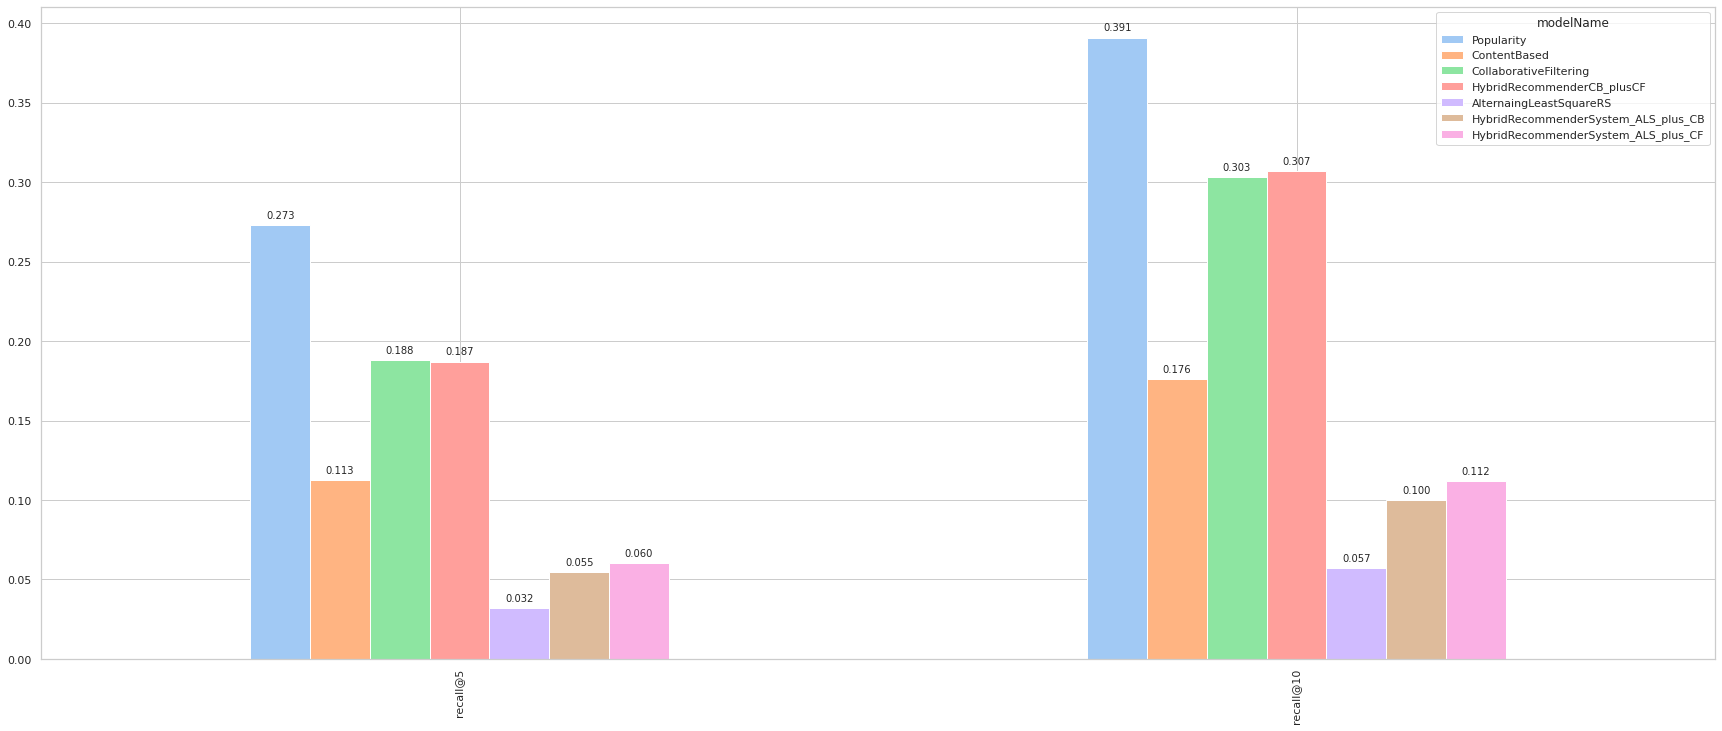

In [90]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(30,12))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

<b>

- Unsurprisingly, The Popularity method beats all other recommender systems, which is generally the case. Items liked by many people are tend to be preferred by other users as well

- Next best performance was achieved from Hybrid model of CB & CF, it was followed by Collaborative Filtering and then by Content Based model

- The ALS model and its hybrid with CB & CF performed poorly on the dataset 
<b>

The Global Metric dataframe is sorted by Recall@10 in descending order. 

In [91]:
global_metrics_df.sort_values(by='recall@10',ascending=False)

,recall@5,recall@10
modelName,,
Popularity,0.272909,0.390924
HybridRecommenderCB_plusCF,0.187023,0.307038
CollaborativeFiltering,0.188024,0.303288
ContentBased,0.112514,0.175897
HybridRecommenderSystem_ALS_plus_CF,0.060383,0.112014
HybridRecommenderSystem_ALS_plus_CB,0.054632,0.100013
AlternaingLeastSquareRS,0.032004,0.057257


## 15. Conclusion

- On User login, They must be shown most popular but in-interacted articles using the Popularity model created above. 
- After which the Hybrid CB+CF model should be used to recommend un-interacted articles to provide personalized experience to the user


Let's use a randomly selected user - `-2979881261169775358` 

<b>Using Popularity Model, Below articles should be shown to the user upon login, which are popular but uninteracted by the user</b>


In [110]:
user_id = -2979881261169775358
recom_selected_user_popularity_model = popularity_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_full_df),topn=25,verbose=True)
recom_selected_user_popularity_model = recom_selected_user_popularity_model.dropna()
recom_selected_user_popularity_model

,item_id,item_url,title,ratings
0,-4029704725707465084,http://www.cnbc.com/2016/12/21/former-google-c...,Former Google career coach shares a visual tri...,342.048750
3,-8208801367848627943,http://www.geekwire.com/2016/ray-kurzweil-worl...,Ray Kurzweil: The world isn't getting worse - ...,210.280296
9,2581138407738454418,https://medium.com/@rdsubhas/10-modern-softwar...,10 Modern Software Over-Engineering Mistakes,185.565803
10,1469580151036142903,https://dev.to/raddikx/dont-document-your-code...,Don't document your code. Code your documentat...,181.803561
12,8657408509986329668,https://medium.com/practical-blend/pull-reques...,Pull request first - Practical Blend,165.678934
14,-4333957157636611418,https://business.stackoverflow.com/blog/why-pr...,Why Programmers Want Private Offices,155.001010
15,-6156751702010469220,https://blog.codinghorror.com/the-broken-windo...,The Broken Window Theory,154.004755
17,1356221992133852808,https://techcrunch.com/2016/07/11/the-brillian...,The brilliant mechanics of PokÃ©mon Go,150.227607
22,5238119115012015307,https://hbr.org/2016/05/embracing-agile,Embracing Agile,131.741735
23,-6728844082024523434,http://merowing.info/2017/01/seniority/,Seniority,125.070949


<b>Next, Following article should be shown at the bottom of the page using Hybrid CF+CB model, which uninteracted by the user but will provide personalized experience based user's interest</b>

In [111]:
user_id = -2979881261169775358
recom_selected_user_cf_cb_model = hybrid_cf_cb_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_full_df),topn=15,verbose=True)
recom_selected_user_cf_cb_model=recom_selected_user_cf_cb_model.dropna().reset_index()[:10]
recom_selected_user_cf_cb_model

,index,item_id,title,item_url,recStrengthHybrid
0,0,-1654063646246197191,Big IT Rising,https://medium.com/@josef_89142/big-it-rising-...,9.952690
1,1,7255021292858609470,An operating model for company-wide agile deve...,http://www.mckinsey.com/business-functions/bus...,9.101484
2,2,-4888170580455425266,Speeding up ReSharper (and Visual Studio),https://www.jetbrains.com/help/resharper/2016....,8.004430
3,4,-6542996094878850014,How One Jira Ticket Made My Employer $1MM/Mont...,https://medium.com/javascript-scene/how-one-ji...,7.182427
4,6,-2479936301516183562,"GitLab launches Issue Boards, an open-source t...",http://venturebeat.com/2016/08/22/gitlab-issue...,5.442705
5,7,2857117417189640073,Running GV sprints inside corporatesâ-âlea...,https://sprintstories.com/running-gv-sprints-i...,5.438327
6,8,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,http://www.geekwire.com/2016/ray-kurzweil-worl...,5.101177
7,9,-5912792039759735631,Five questions boards should ask about IT in a...,http://www.mckinsey.com/business-functions/bus...,4.845008
8,10,5238119115012015307,Embracing Agile,https://hbr.org/2016/05/embracing-agile,4.822523
9,12,-5002383425685129595,Changing change management,http://www.mckinsey.com/global-themes/leadersh...,4.589797


Finally, Let's compare all the top-10 recommendation from all our models for same user id -> `-2979881261169775358`

In [94]:
# user_id = -2979881261169775358
# #
# recom_selected_user_popularity_model = popularity_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),topn=25,verbose=True)
# recom_selected_user_popularity_model = recom_selected_user_popularity_model.dropna()
# recom_selected_user_popularity_model = recom_selected_user_popularity_model.sort_values(by='ratings',ascending=False)
# #
# recom_selected_user_cb_model = content_based_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),topn=10,verbose=True)
# recom_selected_user_cb_model#.dropna()
# #
# recom_selected_user_cf_model = cf_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),topn=15,verbose=True)
# recom_selected_user_cf_model=recom_selected_user_cf_model.dropna().reset_index()[:10]
# #
# recom_selected_user_cf_cb_model = hybrid_cf_cb_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),topn=15,verbose=True)
# recom_selected_user_cf_cb_model=recom_selected_user_cf_cb_model.dropna().reset_index()[:10]
# #
# recom_selected_user_als_model = als_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),topn=15,verbose=True)
# recom_selected_user_als_model=recom_selected_user_als_model.dropna()[:10]
# #
# recom_selected_user_als_cb_model = hybrid_cb_als_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),verbose=True)
# recom_selected_user_als_cb_model
# #
# recom_selected_user_als_cf_model = hybrid_cf_als_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),verbose=True)


In [102]:
user_id = -2979881261169775358
#
recom_selected_user_popularity_model = popularity_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_full_df),topn=25,verbose=True)
recom_selected_user_popularity_model = recom_selected_user_popularity_model.dropna()
recom_selected_user_popularity_model = recom_selected_user_popularity_model.sort_values(by='ratings',ascending=False)
#
recom_selected_user_cb_model = content_based_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_full_df),topn=10,verbose=True)
recom_selected_user_cb_model#.dropna()
#
recom_selected_user_cf_model = cf_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_full_df),topn=15,verbose=True)
recom_selected_user_cf_model=recom_selected_user_cf_model.dropna().reset_index()[:10]
#
recom_selected_user_cf_cb_model = hybrid_cf_cb_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_full_df),topn=15,verbose=True)
recom_selected_user_cf_cb_model=recom_selected_user_cf_cb_model.dropna().reset_index()[:10]
#
recom_selected_user_als_model = als_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_full_df),topn=15,verbose=True)
recom_selected_user_als_model=recom_selected_user_als_model.dropna()[:10]
#
recom_selected_user_als_cb_model = hybrid_cb_als_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_full_df),verbose=True)
recom_selected_user_als_cb_model
#
recom_selected_user_als_cf_model = hybrid_cf_als_recommender_model.recommend_items(user_id,items_to_ignore=get_items_interacted(user_id, interactions_full_df),verbose=True)


In [103]:
popularity_recommedations = recom_selected_user_popularity_model.reset_index()['title'][:10]
cb_recommedations = recom_selected_user_cb_model.reset_index()['title'][:10]
cf_recommedations = recom_selected_user_cf_model.reset_index()['title'][:10]
cf_cb_recommedations = recom_selected_user_cf_cb_model.reset_index()['title'][:10]
als_recommedations = recom_selected_user_als_model.reset_index()['title'][:10]
als_cb_recommedations = recom_selected_user_als_cb_model.reset_index()['title'][:10]
als_cf_recommedations = recom_selected_user_als_cf_model.reset_index()['title'][:10]

In [104]:
all_model_recommendations_selected_user_df = pd.DataFrame([])
all_model_recommendations_selected_user_df['pop_title'] = popularity_recommedations
all_model_recommendations_selected_user_df['cb_title'] = cb_recommedations
all_model_recommendations_selected_user_df['cf_title'] = cf_recommedations
all_model_recommendations_selected_user_df['cf_cb_title'] = cf_cb_recommedations
all_model_recommendations_selected_user_df['als_title'] = als_recommedations
all_model_recommendations_selected_user_df['als_cb_title'] = als_cb_recommedations
all_model_recommendations_selected_user_df['als_cf_title'] = als_cf_recommedations

In [105]:
all_model_recommendations_selected_user_df

,pop_title,cb_title,cf_title,cf_cb_title,als_title,als_cb_title,als_cf_title
0,Former Google career coach shares a visual tri...,Being A Developer After 40 - Free Code Camp,Big IT Rising,Big IT Rising,Peter Doig sued for disavowing 40-year-old pai...,Peter Doig sued for disavowing 40-year-old pai...,Peter Doig sued for disavowing 40-year-old pai...
1,Ray Kurzweil: The world isn't getting worse - ...,What 2 Years of Android Development Have Taugh...,An operating model for company-wide agile deve...,An operating model for company-wide agile deve...,The Children's Illustrated Guide to Kubernetes,Trooly is using machine learning to judge trus...,The Children's Illustrated Guide to Kubernetes
2,10 Modern Software Over-Engineering Mistakes,A Single App That'll Wrangle Your Millions of ...,Speeding up ReSharper (and Visual Studio),Speeding up ReSharper (and Visual Studio),Trooly is using machine learning to judge trus...,Bots won't replace apps. Better apps will repl...,Trooly is using machine learning to judge trus...
3,Don't document your code. Code your documentat...,A Single App That'll Wrangle Your Millions of ...,How One Jira Ticket Made My Employer $1MM/Mont...,How One Jira Ticket Made My Employer $1MM/Mont...,Platforms are the real powerhouses in Silicon ...,Platforms are the real powerhouses in Silicon ...,Platforms are the real powerhouses in Silicon ...
4,Pull request first - Practical Blend,"The Languages, Frameworks and Tools You Should...","GitLab launches Issue Boards, an open-source t...","GitLab launches Issue Boards, an open-source t...",It's coming! The Internet of Eyes will allow o...,It's coming! The Internet of Eyes will allow o...,It's coming! The Internet of Eyes will allow o...
5,Why Programmers Want Private Offices,Leveling Up Your JavaScript -,Running GV sprints inside corporatesâ-âlea...,Running GV sprints inside corporatesâ-âlea...,Brazilian Government and Ericsson to innovate ...,The Children's Illustrated Guide to Kubernetes,Brazilian Government and Ericsson to innovate ...
6,The Broken Window Theory,This year's Founders' Letter,Ray Kurzweil: The world isn't getting worse - ...,Ray Kurzweil: The world isn't getting worse - ...,Bots won't replace apps. Better apps will repl...,"GitHub broke my 1,000 day streak - Free Code Camp",Bots won't replace apps. Better apps will repl...
7,The brilliant mechanics of PokÃ©mon Go,What to look for in a code review,Former Google career coach shares a visual tri...,Five questions boards should ask about IT in a...,The Secret History of Agile Innovation,Brazilian Government and Ericsson to innovate ...,The Secret History of Agile Innovation
8,Embracing Agile,So long MVP. Hello Minimum Loveable Product.,Embracing Agile,Embracing Agile,Million Song Dataset | scaling MIR research,Finding The Meaning Of Artificial Intelligence...,Million Song Dataset | scaling MIR research
9,Seniority,10 Modern Software Over-Engineering Mistakes,Five questions boards should ask about IT in a...,Changing change management,"GitHub broke my 1,000 day streak - Free Code Camp",Approaching (Almost) Any Machine Learning Prob...,"GitHub broke my 1,000 day streak - Free Code Camp"


- We can explode this df to check which article lies in which columns if there are any which are common to all

In [106]:
all_article_recommendations_selected_user= all_model_recommendations_selected_user_df.apply(pd.value_counts).notna()
all_article_recommendations_selected_user

,pop_title,cb_title,cf_title,cf_cb_title,als_title,als_cb_title,als_cf_title
10 Modern Software Over-Engineering Mistakes,True,True,False,False,False,False,False
A Single App That'll Wrangle Your Millions of Messengers,False,True,False,False,False,False,False
An operating model for company-wide agile development,False,False,True,True,False,False,False
Approaching (Almost) Any Machine Learning Problem | Abhishek Thakur,False,False,False,False,False,True,False
Being A Developer After 40 - Free Code Camp,False,True,False,False,False,False,False
Big IT Rising,False,False,True,True,False,False,False
Bots won't replace apps. Better apps will replace apps.,False,False,False,False,True,True,True
Brazilian Government and Ericsson to innovate together for Internet of Things,False,False,False,False,True,True,True
Changing change management,False,False,False,True,False,False,False
Don't document your code. Code your documentation.,True,False,False,False,False,False,False


Articles common to both Collaborative & Hybrid - CF+CB model

In [107]:
all_article_recommendations_selected_user.loc[all_article_recommendations_selected_user['cf_cb_title']==True][all_article_recommendations_selected_user['cf_title'] == True]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,pop_title,cb_title,cf_title,cf_cb_title,als_title,als_cb_title,als_cf_title
An operating model for company-wide agile development,False,False,True,True,False,False,False
Big IT Rising,False,False,True,True,False,False,False
Embracing Agile,True,False,True,True,False,False,False
Five questions boards should ask about IT in a digital world,False,False,True,True,False,False,False
"GitLab launches Issue Boards, an open-source task management tool that resembles Trello",False,False,True,True,False,False,False
How One Jira Ticket Made My Employer $1MM/Month: 7 Metrics that Actually Matter - JavaScript Scene,False,False,True,True,False,False,False
Ray Kurzweil: The world isn't getting worse - our information is getting better,True,False,True,True,False,False,False
Running GV sprints inside corporatesâ-âlearn from my mistakes - Sprint Stories,False,False,True,True,False,False,False
Speeding up ReSharper (and Visual Studio),False,False,True,True,False,False,False


Articles common to both Hybrid ALS+CB & ALS+CF model

In [108]:
all_article_recommendations_selected_user.loc[all_article_recommendations_selected_user['als_cb_title']==True][all_article_recommendations_selected_user['als_cf_title'] == True]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,pop_title,cb_title,cf_title,cf_cb_title,als_title,als_cb_title,als_cf_title
Bots won't replace apps. Better apps will replace apps.,False,False,False,False,True,True,True
Brazilian Government and Ericsson to innovate together for Internet of Things,False,False,False,False,True,True,True
"GitHub broke my 1,000 day streak - Free Code Camp",False,False,False,False,True,True,True
It's coming! The Internet of Eyes will allow objects to see,False,False,False,False,True,True,True
Peter Doig sued for disavowing 40-year-old painting,False,False,False,False,True,True,True
Platforms are the real powerhouses in Silicon Valley's business landscape,False,False,False,False,True,True,True
The Children's Illustrated Guide to Kubernetes,False,False,False,False,True,True,True
Trooly is using machine learning to judge trustworthiness from digital footprints,False,False,False,False,True,True,True


<b>Finally, The article common between Popularity & Hybrid CF+CB model, which should definitely be recommended to the selected user as they are uninteracted by the user yet while most popular and recommended by the model for personalized experience on the platform </b>

In [109]:
all_article_recommendations_selected_user.loc[all_article_recommendations_selected_user['pop_title']==True][all_article_recommendations_selected_user['cf_cb_title'] == True]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,pop_title,cb_title,cf_title,cf_cb_title,als_title,als_cb_title,als_cf_title
Embracing Agile,True,False,True,True,False,False,False
Ray Kurzweil: The world isn't getting worse - our information is getting better,True,False,True,True,False,False,False


---

## 16. The END

by - Abhishek Singh (aulakh.abhishek@gmail.com)

Reach out in case of any assistance with the code